In [1]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error

import keras as K

import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tqdm import tqdm

In [2]:
def compute_y_from_x_cos(X: np.ndarray):
    return np.add(2.0 * X, np.cos(X * 25))#[:, 0] # y = 2x + cos(25x) Not strongly bunched, infinite inflection points

def compute_y_from_x_cosbunched(X: np.ndarray):
    return np.add(0, np.power(np.cos(X * 25), 10))[:, 0] # y = cos(25x)^10 Strongly bunched by this high power

def compute_y_from_x_strongnoise(X: np.ndarray, noise_strength):
    y = np.cos(X * 25) + np.cos(X * 15) # y = cos(25x) + cos(15x) two different frequencies
    noise = np.random.normal(0, 1, y.shape)  # Generate Gaussian noise, with mean 0 and staandard  deviation 1
    y_with_noise = y + noise * noise_strength  # Add Gaussian noise to 'y' values
    return y_with_noise

def compute_y_from_x_noise_lin(X: np.ndarray, noise_strength):
    y = 2.0 * X + np.cos(X * 25) + np.cos(X * 15) # y = 2x + cos(25x) + cos(15x) two different frequencies
    noise = np.random.normal(0, 1, y.shape)  # Generate Gaussian noise, with mean 0 and staandard  deviation 1
    y_with_noise = y + noise * noise_strength  # Add Gaussian noise to 'y' values
    return y_with_noise
    
def compute_y_from_x_noise_brownian(X: np.ndarray, noise_strength):
    y = 5*np.cos(X * 25) + 5*np.cos(X *15) #calculate y to have two frequencies
    noise = np.empty(np.shape(y)) #initialise brownian noise term
    noise[0] = 0 #initialising the first value of the brownian noise array to be 0
    rng = np.random.default_rng() #initialising np random. Gives a float between 0 and 1, uniformly
    for index, val in enumerate(noise[1:]):
        if rng.random() < 0.5: #50/50 chance of subtracting noise_strength term to previous value in list
            noise[index] = noise[index-1] - noise_strength #subtracting noise_strength
        if rng.random() > 0.5: #50/50 chance of adding noise_strength term to previous value in list
            noise[index] = noise[index-1] + noise_strength #adding noise_strength
    y_noisy = y + noise
    return y_noisy

def compute_y_from_x_basic(X: np.ndarray):
    return np.cos(10*X)

In [3]:
#@title NN training on synthetic data with repeats

num_repeats = 2
num_repeat_list = list(range(num_repeats))

# This is the full input data. The validation set is randomly selected as part of KFold
low = -1
high = 1
X = np.linspace(start=low, stop=high, num=10).reshape(-1, 1)
y = compute_y_from_x_basic(X)
# Assuming you have input data 'X' and target data 'y'
#X = np.array([1, 2, 3, 4, 5, 6]).reshape(-1, 1)  # Example input data
#y = np.array([2, 4, 6, 8, 10, 12])  # Example target data

# Define a function to create the neural network model
def create_model(neurons):
    model = Sequential()
    model.add(Dense(neurons, input_dim=1, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Define the number of folds and the list of neurons for the hidden layer
k = 5
#neurons_list = [5, 10, 15]
neurons_list = np.arange(1,30,10, dtype=int)

tf.random.set_seed(None)  # Clear any previous random seed

# Initialize a list to store the evaluation metrics (e.g., MSE) for each fold and each number of neurons
mse_scores = []

for repeat_idx in num_repeat_list:
  random_state = np.random.RandomState(seed=None) #note that the tensorflow random state generator cannot be passed to KFold
  print(random_state)
  for neurons in neurons_list:
    fold_scores = []  # Evaluation scores for the current number of neurons
    kf = KFold(n_splits=k, random_state = random_state, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Create and train the neural network model
        model = create_model(neurons)
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        # Calculate the evaluation metric (e.g., mean squared error)
        mse = mean_squared_error(y_test, y_pred)
        fold_scores.append(mse)

    mse_scores.append(fold_scores)

RandomState(MT19937)
[[0.11111111]
 [0.77777778]]
1/1 [==============================] - 0s 350ms/step
[[-1.        ]
 [-0.33333333]]
1/1 [==============================] - 0s 226ms/step
[[0.33333333]
 [1.        ]]
1/1 [==============================] - 0s 183ms/step
[[-0.11111111]
 [ 0.55555556]]
1/1 [==============================] - 0s 150ms/step
[[-0.77777778]
 [-0.55555556]]
1/1 [==============================] - 0s 317ms/step
[[-1.        ]
 [ 0.77777778]]
1/1 [==============================] - 0s 167ms/step
[[-0.11111111]
 [ 1.        ]]
1/1 [==============================] - 0s 181ms/step
[[-0.55555556]
 [ 0.55555556]]
1/1 [==============================] - 0s 167ms/step
[[-0.33333333]
 [ 0.11111111]]
1/1 [==============================] - 0s 150ms/step
[[-0.77777778]
 [ 0.33333333]]
1/1 [==============================] - 0s 183ms/step
[[-1.        ]
 [-0.11111111]]
1/1 [==============================] - 0s 233ms/step
[[-0.77777778]
 [ 0.55555556]]
1/1 [=======================

C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


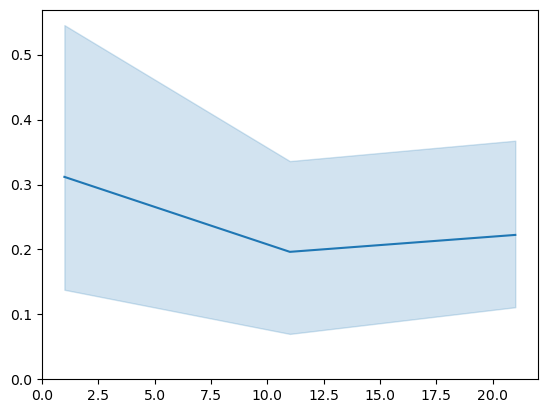

In [4]:
extended_neurons_list = []
for _, sublist in enumerate(mse_scores):
    extended_neurons_list.append([neurons_list[np.mod(_,len(neurons_list))]] * len(sublist))
    #print(extended_neurons_list)
x_values = [val for sublist in extended_neurons_list for val in sublist]
y_values = [val for sublist in mse_scores for val in sublist]
sns.lineplot(x=x_values, y=y_values)
plt.ylim(bottom=0)
plt.show()